<a href="https://colab.research.google.com/github/BlackCurrantDS/Data-Mining/blob/master/Blood_Cell_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools  

import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

Loading dataset

In [7]:
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(60, 80)
    )
validation_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TEST_SIMPLE/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(60, 80))
test_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TEST/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(60, 80))

Found 9977 files belonging to 4 classes.
Found 71 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


In [8]:
#classes in training data
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [9]:
#tensorflow recommnded perfromance options for not letting dataset a bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
dict_characters = {1:'EOSINOPHIL',2:'LYMPHOCYTE',3:'MONOCYTE',4:'NEUTROPHIL'}

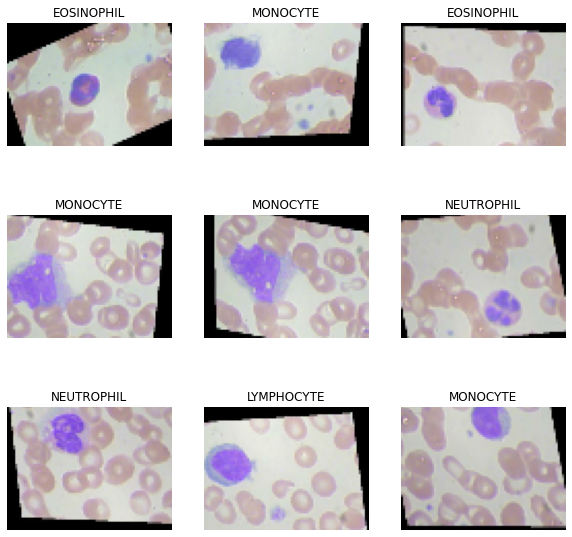

In [11]:
#checking first 10 images from training set

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

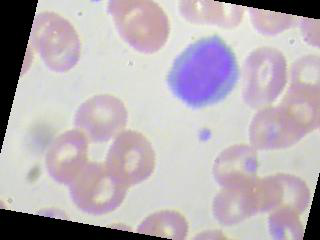

In [12]:
#randomly selecting a sample from LYMPHOCYTE
image_lymp = '/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
get_image_lymp= PIL.Image.open(image_lymp)
get_image_lymp

I can't quite find a difference between LYMPHOCYTE and MONOCYTE, so printing a random sample of MONOCYTE to find clear difference.

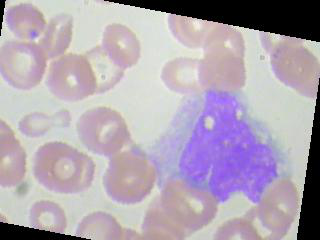

In [13]:
#randomly selecting a sample from MONOCYTE
image_mono = '/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_435.jpeg'
get_image_mono = PIL.Image.open(image_mono)
get_image_mono

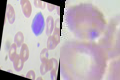

In [14]:
image1 = get_image_lymp.resize((60, 80))
image1_size = image1.size
image2_size = get_image_mono.size
new_image = PIL.Image.new('RGB',(2*image1_size[0], image1_size[1]), (60,80,80))
new_image.paste(image1,(0,0))
new_image.paste(get_image_mono,(image1_size[0],0))
new_image

LYMPHOCYTE looks littel more dense.

In [15]:
#what is the class distribution
labels = pd.read_csv('/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/labels.csv')
labels.head(5)

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL


In [16]:
labels['Category'].value_counts()

NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
NEUTROPHIL, NEUTROPHIL      3
BASOPHIL                    3
NEUTROPHIL, EOSINOPHIL      2
NEUTROPHIL,EOSINOPHIL       1
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL, LYMPHOCYTE      1
LYMPHOCYTE, LYMPHOCYTE      1
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL,EOSINOPHIL       1
MONOCYTE, LYMPHOCYTE        1
NEUTROPHIL,NEUTROPHIL       1
EOSINOPHIL, LYMPHOCYTE      1
Name: Category, dtype: int64

In [ ]:
#train
y = np.concatenate([y for x, y in train_ds], axis=0)
sns.countplot(y)
print(dict_characters)

In [ ]:
#validation
y = np.concatenate([y for x, y in validation_ds], axis=0)
sns.countplot(y)
print(dict_characters)

In [ ]:
#test
labels = np.concatenate([y for x, y in test_ds], axis=0)
sns.countplot(labels)
print(dict_characters)

In [ ]:
#checkpoint
checkpoint_path = "/content/drive/MyDrive/Blood Cell classification/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#model 
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #drop out layer
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

In [ ]:
def plot_learning_curve(history):

          acc = history.history['accuracy']
          val_acc = history.history['val_accuracy']

          loss = history.history['loss']
          val_loss = history.history['val_loss']

          epochs_range = range(epochs)  
          
          plt.figure(figsize=(8, 8))
          plt.subplot(1, 2, 1)
          plt.plot(epochs_range, acc, label='Training Accuracy')
          plt.plot(epochs_range, val_acc, label='Validation Accuracy')
          plt.legend(loc='lower right')
          plt.title('Training and Validation Accuracy')

          plt.subplot(1, 2, 2)
          plt.plot(epochs_range, loss, label='Training Loss')
          plt.plot(epochs_range, val_loss, label='Validation Loss')
          plt.legend(loc='upper right')
          plt.title('Training and Validation Loss')
          plt.show()

In [ ]:
plot_learning_curve(history)

In [ ]:
y_pred = model.predict(test_ds)
predictions = tf.argmax(y_pred, axis=1)

In [ ]:
confusion_mtx = confusion_matrix(labels, predictions)
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))

Using TensorBoard

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
# Reshape the image for the Summary API.
img = np.reshape(train_images[0], (-1, 28, 28, 1))

In [ ]:
# Clear out any prior log data.
!rm -rf logs

# Sets up a timestamped log directory.
logdir = "/content/drive/MyDrive/Blood Cell classification/logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

# Using the file writer, log the reshaped image.
with file_writer.as_default():
  # Don't forget to reshape.
  for images, labels in train_ds.take(1):
    images = np.reshape(images[0:25], (-1, 28, 28, 1))
    tf.summary.image("25 training data examples", images, max_outputs=25, step=0)

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Blood Cell classification/logs/train_data